In [61]:
import sys
import os
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_model_explain_pkg')
import nlpbasic.textClean as textClean
import nlpbasic.docVectors as DocVector
import nlpbasic.dataExploration as DataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf

import model_explain.plot as meplot
import model_explain.shap as meshap

import data_visualization.distribution_plot as dbplot

from numpy import array,asarray,zeros
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import re
import pycountry
from datetime import datetime, timedelta

import plotly.express as px
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data'

Reference:
* https://www.kaggle.com/gpreda/covid-19-vaccination-progress
* https://www.kaggle.com/ivannatarov/covid-19-a-fall-of-darkness-eda-plotly
* https://www.kaggle.com/ivannatarov/covid-19-a-fall-of-darkness-eda-plotly
* https://www.kaggle.com/andreshg/covid-progression-a-plotly-animated-guide

Dataset:
https://www.kaggle.com/josephassaker/covid19-global-dataset

Structure:
* Global Situation: 
    * cumulative case in N and %
    * cumulative vacc in N and %
* Specific Countries: US, Canada, China, India, Israel, others
    * cumulative case in N and %
    * cumulative vacc in N and %
* Map:
    * current infection rate 
    * death rate for covid
    * current vacc rate
    
* Vacc brand:
    * vacc usage in countries
    * diff vacc brand production volume per day
    * 

## Load Data

In [84]:
country_vacc = pd.read_csv(os.path.join(root_path, "country_vaccinations.csv"))
country_vacc_manu = pd.read_csv(os.path.join(root_path, "country_vaccinations_by_manufacturer.csv"))
worldometer_smr = pd.read_csv(os.path.join(root_path, "worldometer_coronavirus_summary_data.csv"))
worldometer_daily = pd.read_csv(os.path.join(root_path, "worldometer_coronavirus_daily_data.csv"))

worldometer_daily['date']=pd.to_datetime(worldometer_daily['date'], errors='coerce').dt.date
country_vacc['date']=pd.to_datetime(country_vacc['date'], errors='coerce').dt.date
country_vacc_manu['date']=pd.to_datetime(country_vacc_manu['date'], errors='coerce').dt.date

In [3]:
worldometer_smr.head(3)

,country,continent,total_confirmed,total_deaths,total_recovered,active_cases,serious_or_critical,total_cases_per_1m_population,total_deaths_per_1m_population,total_tests,total_tests_per_1m_population,population
0,Afghanistan,Asia,70111,2899.0,57119,10093,1124.0,1765,73.0,462860.0,11654.0,39717807
1,Albania,Europe,132285,2448.0,129097,740,18.0,46013,851.0,710160.0,247017.0,2874947
2,Algeria,Africa,128198,3455.0,89232,35511,26.0,2877,78.0,230861.0,5180.0,44565141


In [6]:
worldometer_daily.head(3)

,date,country,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
0,2020-02-15,Afghanistan,0.0,NaN,0.0,0.0,NaN
1,2020-02-16,Afghanistan,0.0,NaN,0.0,0.0,NaN
2,2020-02-17,Afghanistan,0.0,NaN,0.0,0.0,NaN


In [9]:
country_vacc.head(3)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/


In [10]:
country_vacc_manu.head(3)

,location,date,vaccine,total_vaccinations
0,Chile,2020-12-24,Pfizer/BioNTech,420
1,Chile,2020-12-25,Pfizer/BioNTech,5198
2,Chile,2020-12-26,Pfizer/BioNTech,8338


In [5]:
country_vacc_manu.location.unique()

array(['Chile', 'Czechia', 'France', 'Germany', 'Iceland', 'Italy',
       'Latvia', 'Lithuania', 'Romania', 'Switzerland', 'United States'],
      dtype=object)

## Cumulative case and vaccination

In [55]:
vacc_global_count = country_vacc[['total_vaccinations','people_vaccinated','people_fully_vaccinated','date']].groupby('date').agg('sum')
vacc_global_count['vaccination_rate'] = vacc_global_count.people_vaccinated/(worldometer_smr.population.sum())
vacc_global_count['fully_vaccination_rate'] = vacc_global_count.people_fully_vaccinated/(worldometer_smr.population.sum())
vacc_global_count['date'] = vacc_global_count.index
vacc_global_count = vacc_global_count.reset_index(drop=True)
# vacc_global_count.head(3)
covid_global_count = worldometer_daily[['date','cumulative_total_cases', 'cumulative_total_deaths']].groupby('date').agg('sum')
covid_global_count['infection_rate'] = covid_global_count.cumulative_total_cases/(worldometer_smr.population.sum())
covid_global_count['death_rate'] = covid_global_count.cumulative_total_deaths/(covid_global_count.cumulative_total_cases)
covid_global_count['date'] = covid_global_count.index
covid_global_count = covid_global_count.reset_index(drop=True)
# covid_global_count.head(3)
global_data = covid_global_count.merge(vacc_global_count, how = 'left', on = 'date')

# global_data.head(3)

In [69]:
fig = px.line(global_data, x='date', y=['infection_rate', 'vaccination_rate','fully_vaccination_rate','death_rate'],
             title='Global Infection Rate and Vaccination Rate')
fig.show()

In [77]:
fig = px.line(global_data, x='date', y=['cumulative_total_cases','people_vaccinated','people_fully_vaccinated'],
             title='Global Infection Rate and Vaccination Rate')
fig.show()

In [89]:
global_data.head(3)

,cumulative_total_cases,cumulative_total_deaths,infection_rate,death_rate,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,vaccination_rate,fully_vaccination_rate,week_monday
0,571.0,17.0,7.294583e-08,0.029772,2020-01-22,NaN,NaN,NaN,NaN,NaN,2020-01-20
1,830.0,25.0,1.060333e-07,0.030120,2020-01-23,NaN,NaN,NaN,NaN,NaN,2020-01-20
2,1287.0,41.0,1.644156e-07,0.031857,2020-01-24,NaN,NaN,NaN,NaN,NaN,2020-01-20


In [102]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
query = """
select A.date, A.country, 
    A.cumulative_total_cases, A.cumulative_total_deaths, 
    B.total_vaccinations, B.people_vaccinated, B.people_fully_vaccinated,
    A.cumulative_total_cases / C.population as infection_rate,
    A.cumulative_total_deaths / A.cumulative_total_cases as death_rate,
    B.people_vaccinated / C.population as vaccination_rate,
    B.people_fully_vaccinated / C.population as fully_vaccination_rate
from worldometer_daily A
left join country_vacc B on A.date = B.date and A.country = B.country
left join worldometer_smr C on A.country = C.country
"""
country_dataset = pysqldf(query)

In [108]:
country = 'Israel'
fig = px.line(country_dataset[country_dataset.country==country], x='date', 
              y=['death_rate'
                 ,'vaccination_rate'
                 ,'fully_vaccination_rate'
                 ,'infection_rate'
                ],
              title=country + ' Infection Rate and Vaccination Rate')
fig.show()

In [90]:
test.head(3)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
8764,India,IND,2021-01-15,0.0,0.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,"Covaxin, Oxford/AstraZeneca",Government of India,https://dashboard.cowin.gov.in/
8765,India,IND,2021-01-16,191181.0,191181.0,NaN,191181.0,191181.0,0.01,0.01,NaN,139.0,"Covaxin, Oxford/AstraZeneca",Government of India,https://dashboard.cowin.gov.in/
8766,India,IND,2021-01-17,224301.0,224301.0,NaN,33120.0,112150.0,0.02,0.02,NaN,81.0,"Covaxin, Oxford/AstraZeneca",Government of India,https://dashboard.cowin.gov.in/


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


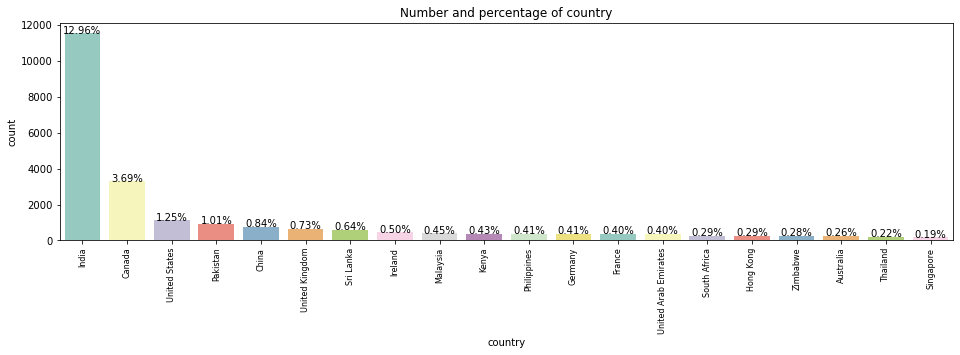

In [13]:
dbplot.plot_count_dist("country", "country", data, 4, True)

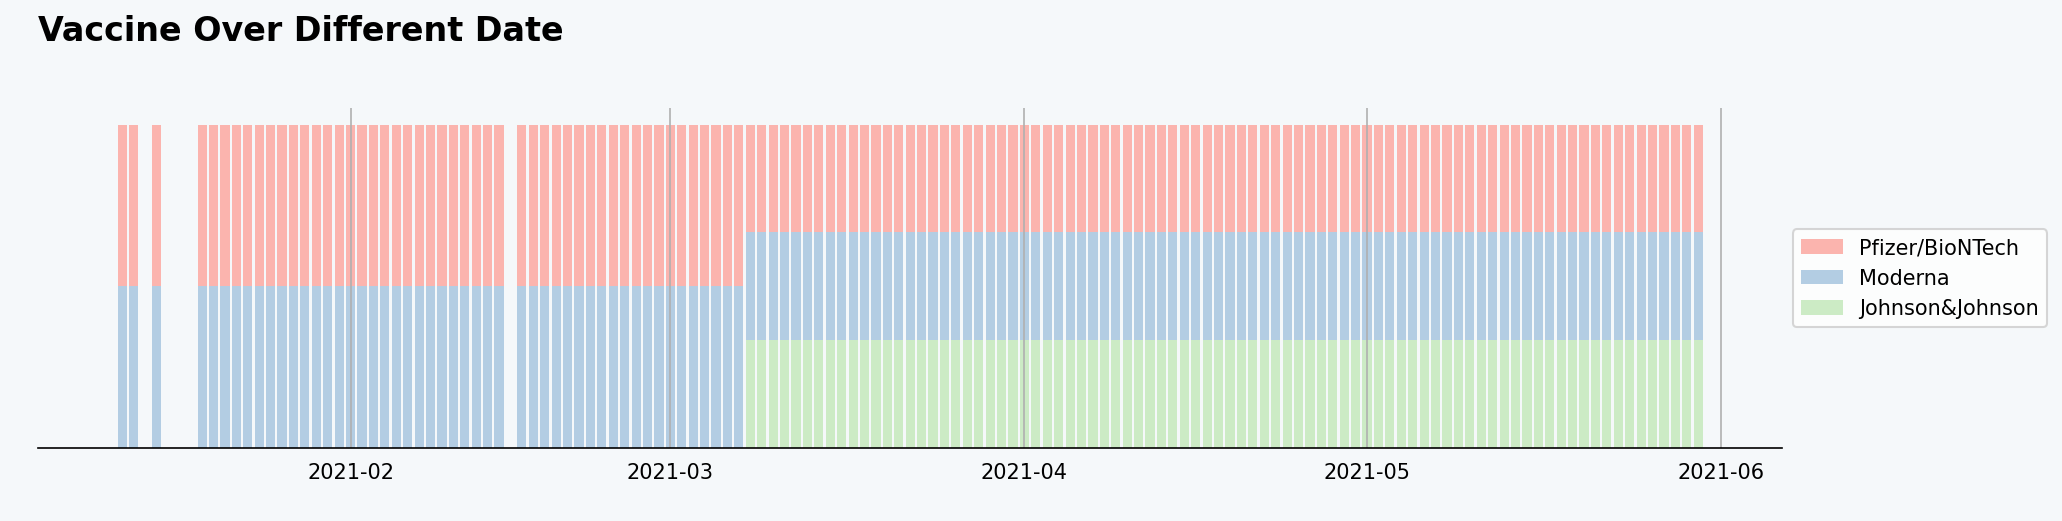

In [11]:
dbplot.generate_bar_proportion(country_vacc_manu[country_vacc_manu.location=='United States'], 'vaccine', 'date', color = 0, order = False, topn = 10)